In [1]:
!pip install pandas numpy scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Load the data
def load_data(filepath):
    """Load and preprocess the dataset"""
    df = pd.read_csv(filepath)
    X = df.drop('Grades', axis=1)
    y = df['Grades']
    return X, y

# Feature Selection Methods

def gini_importance(X, y):
    """Calculate Gini importance using Random Forest"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importance = pd.DataFrame({
        'feature': X.columns,
        'gini_importance': rf.feature_importances_
    })
    return importance.sort_values('gini_importance', ascending=False)

def mutual_information(X, y):
    """Calculate Mutual Information scores"""
    mi_scores = mutual_info_regression(X, y)
    importance = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    })
    return importance.sort_values('mi_score', ascending=False)

def firefly_algorithm(X, y, n_fireflies=20, n_generations=50, alpha=0.5, beta0=1.0, gamma=0.01):
    """Firefly Algorithm for feature selection"""
    n_features = X.shape[1]

    # Initialize fireflies (binary vectors representing feature selection)
    fireflies = np.random.randint(2, size=(n_fireflies, n_features))
    light_intensity = np.zeros(n_fireflies)

    for generation in range(n_generations):
        # Evaluate light intensity (fitness) for each firefly
        for i in range(n_fireflies):
            selected_features = fireflies[i] == 1
            if sum(selected_features) == 0:
                light_intensity[i] = 0
                continue

            X_selected = X.iloc[:, selected_features]
            rf = RandomForestRegressor(n_estimators=50, random_state=42)
            scores = cross_val_score(rf, X_selected, y, cv=5)
            light_intensity[i] = np.mean(scores)

        # Move fireflies
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if light_intensity[j] > light_intensity[i]:
                    # Calculate distance
                    r = np.sum(np.abs(fireflies[i] - fireflies[j]))
                    # Update position
                    attractiveness = beta0 * np.exp(-gamma * r**2)
                    fireflies[i] = fireflies[i] + attractiveness * (fireflies[j] - fireflies[i])
                    fireflies[i] = np.where(np.random.random(n_features) < alpha,
                                          1 - fireflies[i],
                                          fireflies[i])
                    # Ensure binary values
                    fireflies[i] = np.where(fireflies[i] > 0.5, 1, 0)

    # Find best solution
    best_firefly_idx = np.argmax(light_intensity)
    selected_features = fireflies[best_firefly_idx] == 1

    return pd.DataFrame({
        'feature': X.columns,
        'selected': selected_features
    })

# Prediction Models

def train_svm(X_train, X_test, y_train, y_test):
    """Train and evaluate SVM model"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm = SVR(kernel='rbf')
    svm.fit(X_train_scaled, y_train)

    y_pred = svm.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': svm,
        'mse': mse,
        'r2': r2,
        'predictions': y_pred
    }

def train_random_forest(X_train, X_test, y_train, y_test):
    """Train and evaluate Random Forest model"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': rf,
        'mse': mse,
        'r2': r2,
        'predictions': y_pred
    }

# Main execution
def main():
    # Load data
    X, y = load_data('data.csv')

    # Get feature selections from each method
    print("=== Feature Selection Results ===\n")

    # Gini Importance
    print("1. Gini Importance:")
    gini_results = gini_importance(X, y)
    print(gini_results)
    gini_features = gini_results['feature'].tolist()
    print("\n")

    # Mutual Information
    print("2. Mutual Information:")
    mi_results = mutual_information(X, y)
    print(mi_results)
    mi_features = mi_results['feature'].tolist()
    print("\n")

    # Firefly Algorithm
    print("3. Firefly Algorithm:")
    firefly_results = firefly_algorithm(X, y)
    print(firefly_results)
    firefly_features = firefly_results[firefly_results['selected']]['feature'].tolist()
    print("\n")

    # Dictionary to store all results
    all_results = {}

    # Test each combination of feature selection method and model
    feature_selections = {
        'Gini': gini_features,
        'Mutual Information': mi_features,
        'Firefly': firefly_features
    }

    print("=== Model Evaluation with Different Feature Selections ===\n")

    for method_name, selected_features in feature_selections.items():
        print(f"\nTesting with {method_name} selected features:")
        print(f"Selected features: {selected_features}")

        # Select features
        X_selected = X[selected_features]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y, test_size=0.2, random_state=42
        )

        # Test SVM
        print("\nSupport Vector Machine:")
        svm_results = train_svm(X_train, X_test, y_train, y_test)
        print(f"MSE: {svm_results['mse']:.4f}")
        print(f"R2 Score: {svm_results['r2']:.4f}")

        # Store results
        all_results[f'SVM with {method_name}'] = {
            'mse': svm_results['mse'],
            'r2': svm_results['r2']
        }

        # Test Random Forest
        print("\nRandom Forest:")
        rf_results = train_random_forest(X_train, X_test, y_train, y_test)
        print(f"MSE: {rf_results['mse']:.4f}")
        print(f"R2 Score: {rf_results['r2']:.4f}")

        # Store results
        all_results[f'Random Forest with {method_name}'] = {
            'mse': rf_results['mse'],
            'r2': rf_results['r2']
        }

    # Print final comparison
    print("\n=== Final Comparison ===")
    print("\nSorted by R² Score (higher is better):")
    r2_comparison = pd.DataFrame.from_dict(all_results, orient='index')
    print(r2_comparison.sort_values('r2', ascending=False))

if __name__ == "__main__":
    main()

=== Feature Selection Results ===

1. Gini Importance:
               feature  gini_importance
1          Study Hours         0.738746
0  Socioeconomic Score         0.249694
2          Sleep Hours         0.006268
3       Attendance (%)         0.005292


2. Mutual Information:
               feature  mi_score
1          Study Hours  0.804142
0  Socioeconomic Score  0.159501
3       Attendance (%)  0.052998
2          Sleep Hours  0.027057


3. Firefly Algorithm:
               feature  selected
0  Socioeconomic Score      True
1          Study Hours      True
2          Sleep Hours      True
3       Attendance (%)      True


=== Model Evaluation with Different Feature Selections ===


Testing with Gini selected features:
Selected features: ['Study Hours', 'Socioeconomic Score', 'Sleep Hours', 'Attendance (%)']

Support Vector Machine:
MSE: 6.9775
R2 Score: 0.9076

Random Forest:
MSE: 1.4467
R2 Score: 0.9808

Testing with Mutual Information selected features:
Selected features: ['Stu

In [3]:
!pip install seaborn matplotlib pandas numpy

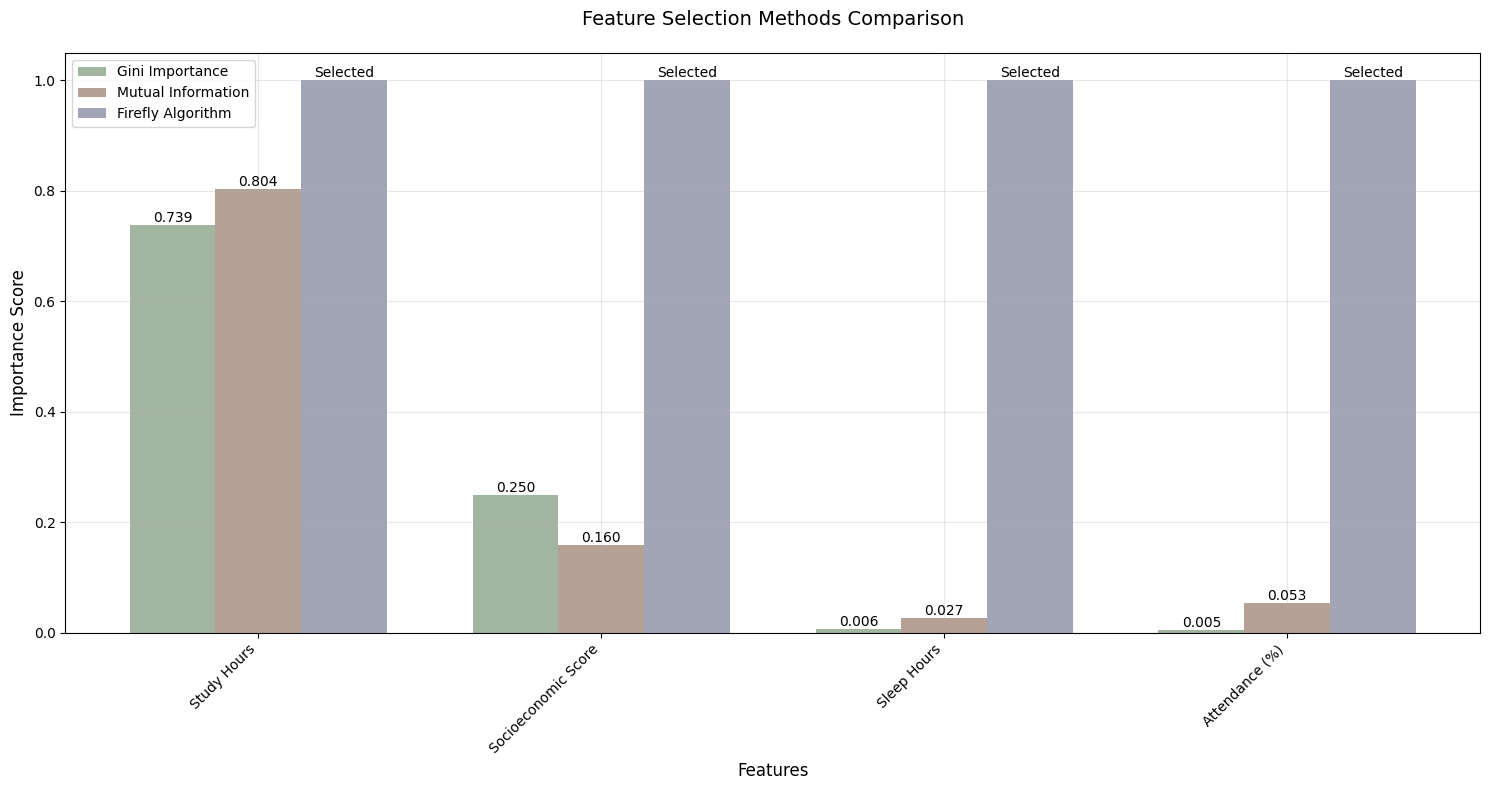

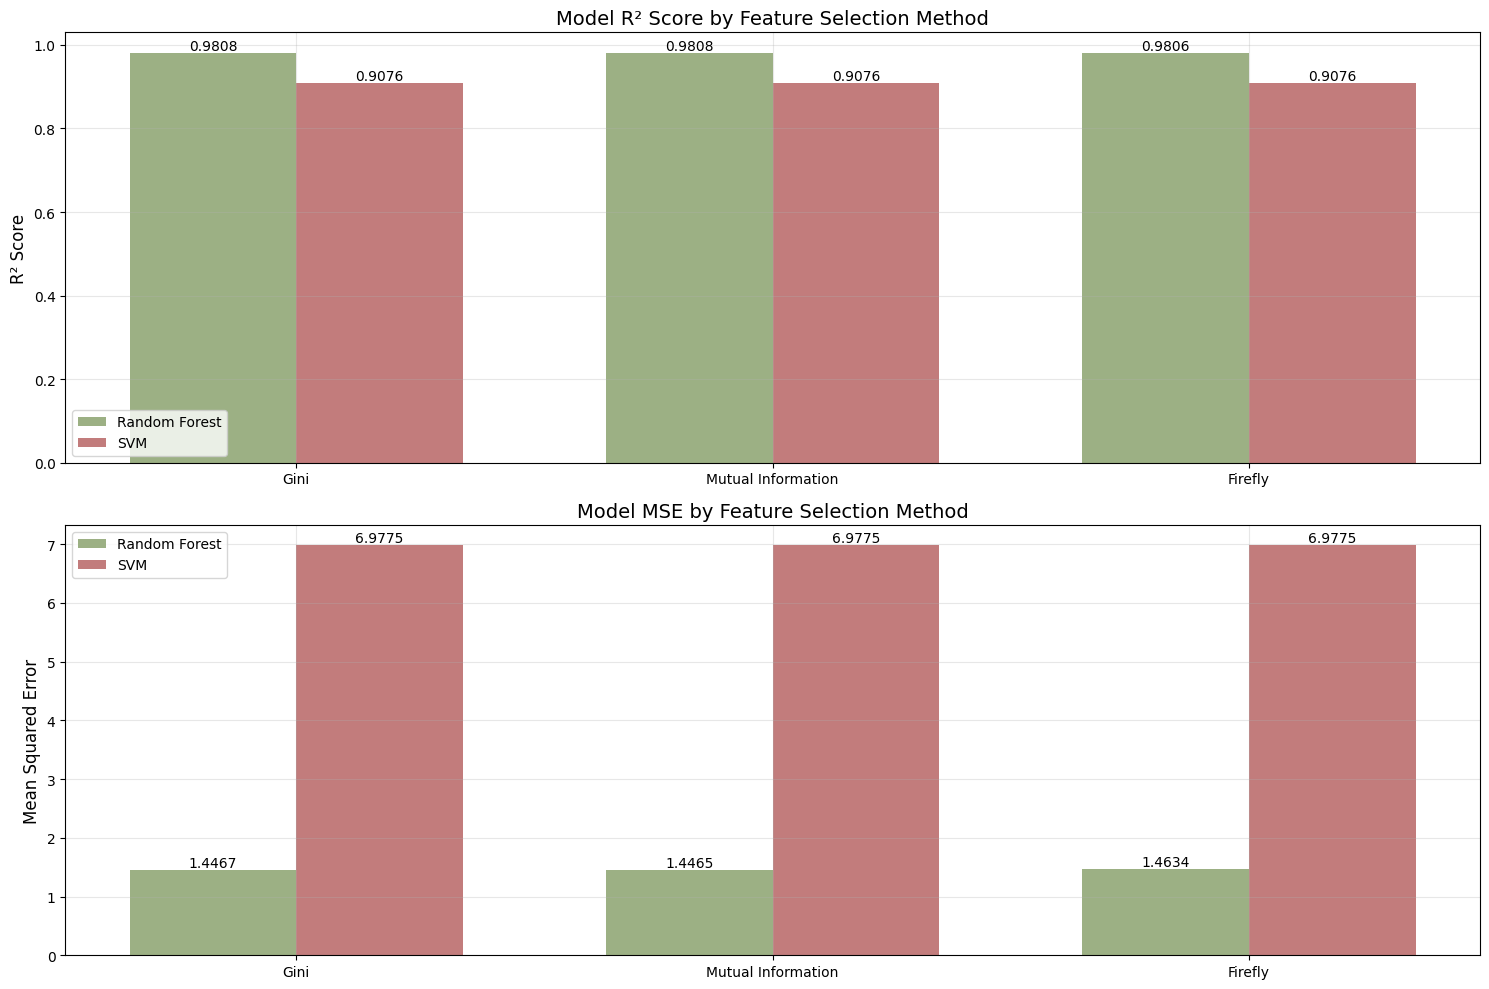

In [11]:
import matplotlib.pyplot as plt
import numpy as np

colors = {
    'gi': '#A1B5A1',
    'mi': '#B5A196',
    'firefly': '#A1A5B5',
    'rf': '#9CB084',
    'svm': '#C27C7C'
}

# First Figure: Feature Selection Methods Comparison
plt.figure(figsize=(15, 8))

features = ['Study Hours', 'Socioeconomic Score', 'Sleep Hours', 'Attendance (%)']
gi_scores = [0.738746, 0.249694, 0.006268, 0.005292]
mi_scores = [0.804142, 0.159501, 0.027057, 0.052998]
firefly_scores = [1, 1, 1, 1]

x = np.arange(len(features))
width = 0.25

plt.bar(x - width, gi_scores, width, label='Gini Importance', color=colors['gi'])
plt.bar(x, mi_scores, width, label='Mutual Information', color=colors['mi'])
plt.bar(x + width, firefly_scores, width, label='Firefly Algorithm', color=colors['firefly'])

plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.title('Feature Selection Methods Comparison', fontsize=14, pad=20)
plt.xticks(x, features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

for i in range(len(features)):
    plt.text(i - width, gi_scores[i], f'{gi_scores[i]:.3f}', ha='center', va='bottom')
    plt.text(i, mi_scores[i], f'{mi_scores[i]:.3f}', ha='center', va='bottom')
    plt.text(i + width, firefly_scores[i], 'Selected', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Second Figure: Model Performance by Feature Selection Method
plt.figure(figsize=(15, 10))

# Performance metrics
methods = ['Gini', 'Mutual Information', 'Firefly']
rf_r2 = [0.980833, 0.980836, 0.980612]
svm_r2 = [0.907559, 0.907559, 0.907559]
rf_mse = [1.446719, 1.446538, 1.463378]
svm_mse = [6.977456, 6.977456, 6.977456]

# R² Score subplot
plt.subplot(2, 1, 1)
x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, rf_r2, width, label='Random Forest', color=colors['rf'])
plt.bar(x + width/2, svm_r2, width, label='SVM', color=colors['svm'])

plt.ylabel('R² Score', fontsize=12)
plt.title('Model R² Score by Feature Selection Method', fontsize=14)
plt.xticks(x, methods)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i in range(len(methods)):
    plt.text(i - width/2, rf_r2[i], f'{rf_r2[i]:.4f}', ha='center', va='bottom')
    plt.text(i + width/2, svm_r2[i], f'{svm_r2[i]:.4f}', ha='center', va='bottom')

# MSE subplot
plt.subplot(2, 1, 2)
plt.bar(x - width/2, rf_mse, width, label='Random Forest', color=colors['rf'])
plt.bar(x + width/2, svm_mse, width, label='SVM', color=colors['svm'])

plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Model MSE by Feature Selection Method', fontsize=14)
plt.xticks(x, methods)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i in range(len(methods)):
    plt.text(i - width/2, rf_mse[i], f'{rf_mse[i]:.4f}', ha='center', va='bottom')
    plt.text(i + width/2, svm_mse[i], f'{svm_mse[i]:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()